In [1]:
# JUPYTER NOTEBOOK CELL

%matplotlib inline
from pathlib import Path
import re
from typing import Optional, List
import io

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Image as IPyImage

# --------- EDIT THESE PATHS IF NEEDED ---------
RUN_ROOT = Path("/Users/basil/Downloads/content/runs/20250921_130015")
FIG_DIR  = RUN_ROOT / "figures"
CKPT_DIR = RUN_ROOT / "checkpoints"   # only needed if you do latent interpolation
# ----------------------------------------------

# Your grids were saved with nrow=8 in the training script; change if different
N_COLS = 8
PAD = 2

assert FIG_DIR.exists(), f"Figure folder not found: {FIG_DIR}"
print("Figures:", FIG_DIR)
print("Checkpoints (optional):", CKPT_DIR)




Figures: /Users/basil/Downloads/content/runs/20250921_130015/figures
Checkpoints (optional): /Users/basil/Downloads/content/runs/20250921_130015/checkpoints


In [2]:
# JUPYTER NOTEBOOK CELL

def latest_epoch_file(run_dir: Path, prefix: str, suffix: str) -> Optional[Path]:
    """
    Finds the path with the highest epoch number matching e.g. prefix='gan_epoch', suffix='_samples.png'
    """
    pattern = re.compile(rf"{re.escape(prefix)}(\d+){re.escape(suffix)}")
    candidates = []
    for p in run_dir.glob(f"{prefix}*{suffix}"):
        m = pattern.match(p.name)
        if m:
            candidates.append((int(m.group(1)), p))
    if not candidates:
        return None
    return sorted(candidates, key=lambda x: x[0])[-1][1]

def crop_grid_tile(img_path: Path, row: int, col: int, ncols: int = N_COLS, pad: int = PAD) -> Image.Image:
    """
    Crop (row, col) tile from a torchvision.make_grid-style image with uniform padding.
    Assumes square tiles (e.g., CIFAR-like); adjust if your dataset is not square.
    """
    im = Image.open(img_path).convert("RGB")
    W, H = im.size
    tile_w = (W - pad*(ncols-1)) // ncols
    tile_h = tile_w
    x0 = col * (tile_w + pad)
    y0 = row * (tile_h + pad)
    x0 = min(max(0, x0), W - tile_w)
    y0 = min(max(0, y0), H - tile_h)
    return im.crop((x0, y0, x0 + tile_w, y0 + tile_h))

def show_imgs_row(imgs: List[Image.Image], titles: Optional[List[str]] = None, suptitle: Optional[str] = None, dpi=150):
    cols = len(imgs)
    plt.figure(figsize=(max(3, cols*1.6), 1.9), dpi=dpi)
    for i, im in enumerate(imgs):
        ax = plt.subplot(1, cols, i+1)
        ax.imshow(im)
        ax.axis("off")
        if titles and i < len(titles):
            ax.set_title(titles[i], fontsize=9)
    if suptitle:
        plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

def inline_gif(frames: List[Image.Image], duration_ms: int = 120):
    """
    Build a GIF in-memory and display it inline (no disk writes).
    """
    bio = io.BytesIO()
    # Save as GIF into the buffer
    frames[0].save(
        bio, format="GIF", save_all=True, append_images=frames[1:], duration=duration_ms,
        loop=0, optimize=True, disposal=2
    )
    bio.seek(0)
    display(IPyImage(data=bio.read(), format='gif'))


In [3]:
# JUPYTER NOTEBOOK CELL

gan_samples = latest_epoch_file(FIG_DIR, "gan_epoch", "_samples.png")
vae_orig    = latest_epoch_file(FIG_DIR, "vae_epoch", "_orig.png")
vae_recon   = latest_epoch_file(FIG_DIR, "vae_epoch", "_recon.png")

print("Detected latest files:")
print("  GAN samples:", gan_samples)
print("  VAE orig:   ", vae_orig)
print("  VAE recon:  ", vae_recon)

available = {k:v for k,v in {"gan":gan_samples, "vae_orig":vae_orig, "vae_recon":vae_recon}.items() if v is not None}
assert available, "No grids found in FIG_DIR. Make sure your figure files exist."


Detected latest files:
  GAN samples: /Users/basil/Downloads/content/runs/20250921_130015/figures/gan_epoch030_samples.png
  VAE orig:    /Users/basil/Downloads/content/runs/20250921_130015/figures/vae_epoch030_orig.png
  VAE recon:   /Users/basil/Downloads/content/runs/20250921_130015/figures/vae_epoch030_recon.png


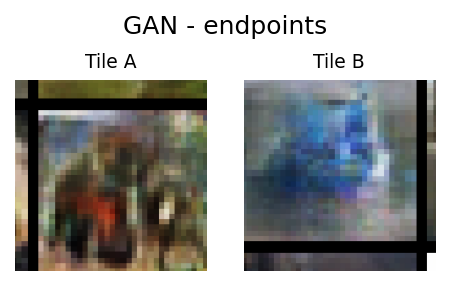

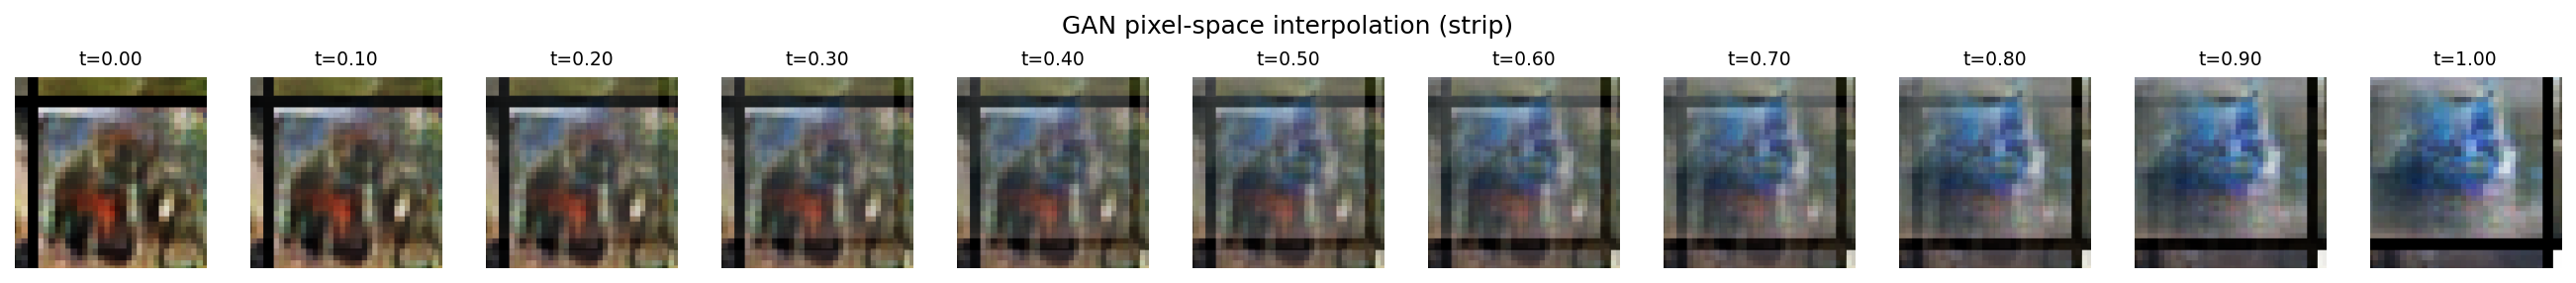

Inline GIF preview:


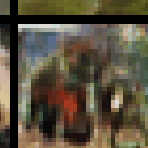

In [4]:
# JUPYTER NOTEBOOK CELL

# --- Choose grid and two tiles to interpolate between ---
WHICH = "gan"            # "gan", "vae_orig", or "vae_recon"
ROW_A, COL_A = 1, 2      # change to explore
ROW_B, COL_B = 6, 5
STEPS = 11               # number of interpolation frames (>=2)

grid_path = {"gan": gan_samples, "vae_orig": vae_orig, "vae_recon": vae_recon}[WHICH]
assert grid_path is not None, f"No grid found for {WHICH}"

# Extract tiles
tileA = crop_grid_tile(grid_path, ROW_A, COL_A, ncols=N_COLS, pad=PAD)
tileB = crop_grid_tile(grid_path, ROW_B, COL_B, ncols=N_COLS, pad=PAD)

# Preview endpoints
show_imgs_row([tileA, tileB], titles=["Tile A", "Tile B"], suptitle=f"{WHICH.upper()} - endpoints")

# Alpha-blend frames in pixel space
def alpha_blend(A: Image.Image, B: Image.Image, t: float) -> Image.Image:
    if A.size != B.size:
        B = B.resize(A.size, Image.BICUBIC)
    return Image.blend(A, B, alpha=float(t))

ts = np.linspace(0.0, 1.0, max(2, STEPS)).tolist()
frames = [alpha_blend(tileA, tileB, t) for t in ts]

# Display as a row (static strip)
titles = [f"t={t:.2f}" for t in ts]
show_imgs_row(frames, titles=titles, suptitle=f"{WHICH.upper()} pixel-space interpolation (strip)")

# Display as an inline GIF animation (built in memory)
print("Inline GIF preview:")
inline_gif(frames, duration_ms=120)


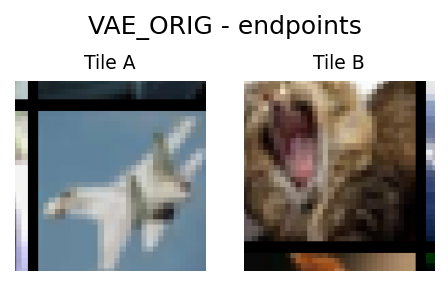

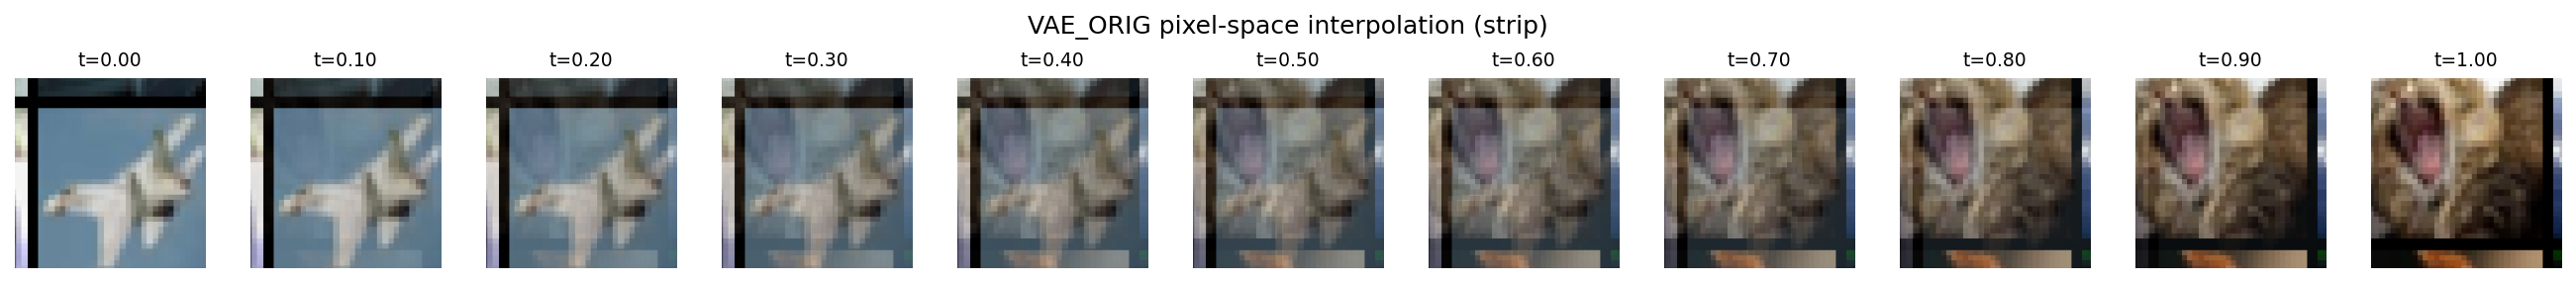

Inline GIF preview:


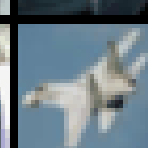

In [ ]:

WHICH = "vae_orig"            
ROW_A, COL_A = 1, 2     
ROW_B, COL_B = 6, 5
STEPS = 11               

grid_path = {"gan": gan_samples, "vae_orig": vae_orig, "vae_recon": vae_recon}[WHICH]
assert grid_path is not None, f"No grid found for {WHICH}"

tileA = crop_grid_tile(grid_path, ROW_A, COL_A, ncols=N_COLS, pad=PAD)
tileB = crop_grid_tile(grid_path, ROW_B, COL_B, ncols=N_COLS, pad=PAD)

show_imgs_row([tileA, tileB], titles=["Tile A", "Tile B"], suptitle=f"{WHICH.upper()} - endpoints")

def alpha_blend(A: Image.Image, B: Image.Image, t: float) -> Image.Image:
    if A.size != B.size:
        B = B.resize(A.size, Image.BICUBIC)
    return Image.blend(A, B, alpha=float(t))

ts = np.linspace(0.0, 1.0, max(2, STEPS)).tolist()
frames = [alpha_blend(tileA, tileB, t) for t in ts]

titles = [f"t={t:.2f}" for t in ts]
show_imgs_row(frames, titles=titles, suptitle=f"{WHICH.upper()} pixel-space interpolation (strip)")

print("Inline GIF preview:")
inline_gif(frames, duration_ms=120)


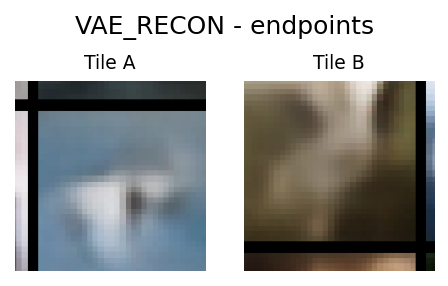

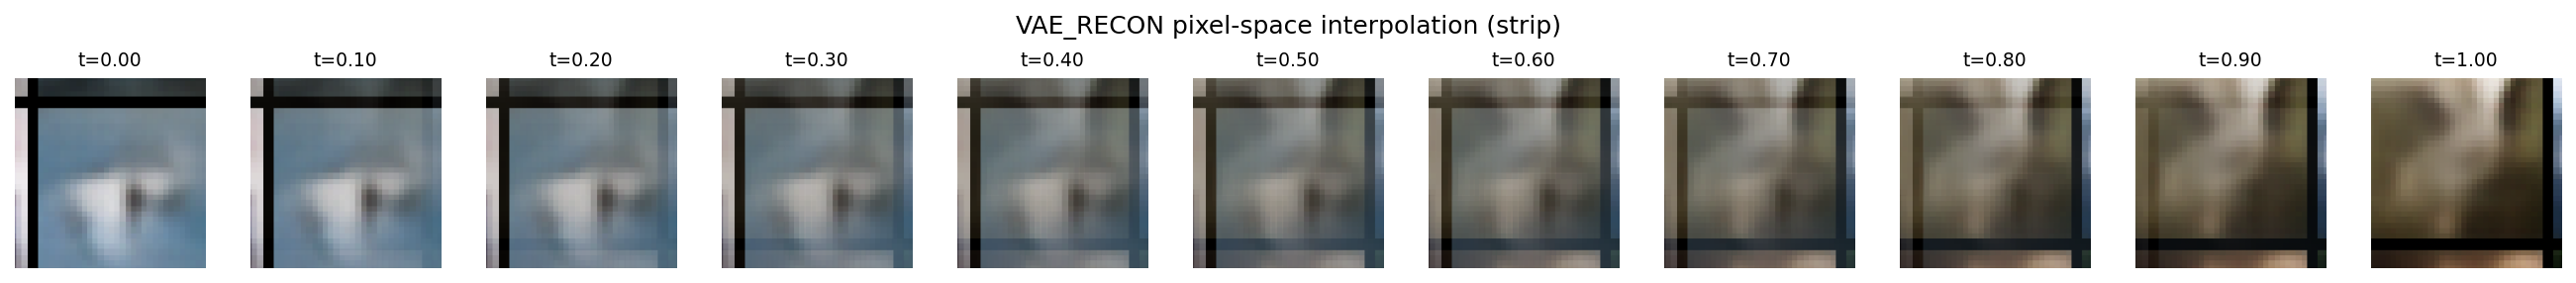

Inline GIF preview:


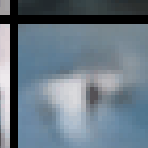

In [ ]:

WHICH = "vae_recon"           
ROW_A, COL_A = 1, 2      
ROW_B, COL_B = 6, 5
STEPS = 11             

grid_path = {"gan": gan_samples, "vae_orig": vae_orig, "vae_recon": vae_recon}[WHICH]
assert grid_path is not None, f"No grid found for {WHICH}"

# Extract tiles
tileA = crop_grid_tile(grid_path, ROW_A, COL_A, ncols=N_COLS, pad=PAD)
tileB = crop_grid_tile(grid_path, ROW_B, COL_B, ncols=N_COLS, pad=PAD)

# Preview endpoints
show_imgs_row([tileA, tileB], titles=["Tile A", "Tile B"], suptitle=f"{WHICH.upper()} - endpoints")

# Alpha-blend frames in pixel space
def alpha_blend(A: Image.Image, B: Image.Image, t: float) -> Image.Image:
    if A.size != B.size:
        B = B.resize(A.size, Image.BICUBIC)
    return Image.blend(A, B, alpha=float(t))

ts = np.linspace(0.0, 1.0, max(2, STEPS)).tolist()
frames = [alpha_blend(tileA, tileB, t) for t in ts]

# Display as a row (static strip)
titles = [f"t={t:.2f}" for t in ts]
show_imgs_row(frames, titles=titles, suptitle=f"{WHICH.upper()} pixel-space interpolation (strip)")

# Display as an inline GIF animation (built in memory)
print("Inline GIF preview:")
inline_gif(frames, duration_ms=120)
